### The dataset
http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

### Attribute Information:

* 1.date: Date in format dd/mm/yyyy 
* 2.time: time in format hh:mm:ss 
* 3.global_active_power: household global minute-averaged active power (in kilowatt) 
* 4.global_reactive_power: household global minute-averaged reactive power (in kilowatt) 
* 5.voltage: minute-averaged voltage (in volt) 
* 6.global_intensity: household global minute-averaged current intensity (in ampere) 
* 7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
* 8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. 
* 9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

Import everything

In [1]:
import sys 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

/Users/gujgicza/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Importing the data and data processing

In [2]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### Data preparation

Dealing with 'nan' values

In [4]:
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [5]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


Get information from the time index

In [6]:
df['Month'] = df.index.month
df['DayOfWeek'] = df.index.dayofweek
df['Hour'] = df.index.hour
df['Season'] = (df.index.month%12 + 3)//3

In [7]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month,DayOfWeek,Hour,Season
dt,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,12,5,17,1
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,12,5,17,1
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,12,5,17,1
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,12,5,17,1
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,12,5,17,1


### Data preparation

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Resampling to shorten training time

In [9]:
df_resample = df.resample('h').mean() 

In [10]:
values = df_resample.values 

Scaling

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 3, 1)

In [12]:
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t)
3,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,1.0,0.833333,0.739130,...,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,1.0,0.833333,0.869565,0.0
4,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,1.0,0.833333,0.782609,...,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,1.0,0.833333,0.913043,0.0
5,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,1.0,0.833333,0.826087,...,0.072536,0.495847,0.323529,0.0,0.002872,0.205723,1.0,0.833333,0.956522,0.0
6,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,1.0,0.833333,0.869565,...,0.092251,0.567188,0.301052,0.0,0.001795,0.000000,1.0,0.833333,1.000000,0.0
7,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,1.0,0.833333,0.913043,...,0.132286,0.580314,0.273434,0.0,0.010050,0.000000,1.0,1.000000,0.000000,0.0


Predict only Global active power (var1) at time t

In [13]:
reframed.drop(reframed.columns[-10:], axis=1, inplace=True)

In [14]:
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var1(t)
3,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,1.0,0.833333,0.739130,...,0.283802,0.502152,0.0,0.030869,0.774169,1.0,0.833333,0.826087,0.0,0.488550
4,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,1.0,0.833333,0.782609,...,0.315987,0.481110,0.0,0.000000,0.778809,1.0,0.833333,0.869565,0.0,0.455597
5,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,1.0,0.833333,0.826087,...,0.434417,0.449904,0.0,0.008973,0.798917,1.0,0.833333,0.913043,0.0,0.322555
6,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,1.0,0.833333,0.869565,...,0.495847,0.323529,0.0,0.002872,0.205723,1.0,0.833333,0.956522,0.0,0.301032
7,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,1.0,0.833333,0.913043,...,0.567188,0.301052,0.0,0.001795,0.000000,1.0,0.833333,1.000000,0.0,0.273201


In [15]:
reframed.shape

(34586, 34)

### Split the data to train, validation and test set

In [16]:
values = reframed.values

n_train_time = 365 * 24  # 8760
n_valid_time = 2 * 365 * 24
train = values[:n_train_time, :]
validation = values[n_train_time:n_valid_time, :]
test = values[n_valid_time:, :]

In [17]:
# shuffle the train set
np.random.shuffle(train)

In [18]:
# split into inputs and outputs
train_X, train_y = train[:, :-1], train[:, -1]
valid_X, valid_y = validation[:, :-1], validation[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [19]:
train_X.shape

(8760, 33)

In [20]:
train_y.shape

(8760,)

Reshape input to be 3D [samples, timesteps, features]

In [21]:
train_X = train_X.reshape((train_X.shape[0], 3, train_X.shape[1]//3))
valid_X = valid_X.reshape((valid_X.shape[0], 3, valid_X.shape[1]//3))
test_X = test_X.reshape((test_X.shape[0], 3, test_X.shape[1]//3))

In [22]:
train_X.shape

(8760, 3, 11)

In [23]:
train_y.shape

(8760,)

### Model architecture

 - CNN with 11 output filters
 - Dropout layer (30%)
 - LSTM with 100 neurons in the first visible layer 
 - Dropout layer (20%)
 - 1 neuron in the output layer for predicting global active energy. 
 - The input shape will be 3 time step each with 11 features.
 - Mean Squared Error loss function and the efficient Adam version of stochastic gradient descent.

In [24]:
model = Sequential()
model.add(Conv1D(11, 2, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Fit network
 - 20 training epochs with a batch size of 70.

In [25]:
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(valid_X, valid_y), 
                    verbose=2, shuffle=False)

Train on 8760 samples, validate on 8760 samples
Epoch 1/20
 - 2s - loss: 0.0211 - val_loss: 0.0138
Epoch 2/20
 - 1s - loss: 0.0162 - val_loss: 0.0119
Epoch 3/20
 - 1s - loss: 0.0143 - val_loss: 0.0114
Epoch 4/20
 - 1s - loss: 0.0136 - val_loss: 0.0106
Epoch 5/20
 - 1s - loss: 0.0132 - val_loss: 0.0102
Epoch 6/20
 - 1s - loss: 0.0125 - val_loss: 0.0100
Epoch 7/20
 - 1s - loss: 0.0123 - val_loss: 0.0099
Epoch 8/20
 - 1s - loss: 0.0120 - val_loss: 0.0097
Epoch 9/20
 - 1s - loss: 0.0119 - val_loss: 0.0096
Epoch 10/20
 - 1s - loss: 0.0116 - val_loss: 0.0095
Epoch 11/20
 - 1s - loss: 0.0115 - val_loss: 0.0095
Epoch 12/20
 - 1s - loss: 0.0114 - val_loss: 0.0094
Epoch 13/20
 - 1s - loss: 0.0112 - val_loss: 0.0093
Epoch 14/20
 - 1s - loss: 0.0111 - val_loss: 0.0093
Epoch 15/20
 - 1s - loss: 0.0109 - val_loss: 0.0092
Epoch 16/20
 - 1s - loss: 0.0109 - val_loss: 0.0091
Epoch 17/20
 - 1s - loss: 0.0109 - val_loss: 0.0091
Epoch 18/20
 - 1s - loss: 0.0106 - val_loss: 0.0092
Epoch 19/20
 - 1s - loss:

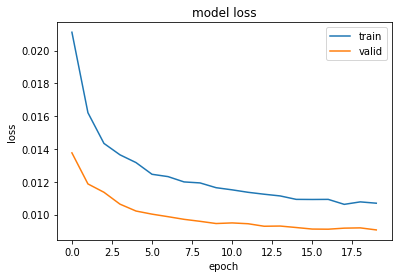

In [26]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [27]:
test_X.shape

(17066, 3, 11)

In [28]:
yhat = model.predict(test_X)

In [29]:
yhat.shape

(17066, 1)

In [30]:
test_X = test_X.reshape((test_X.shape[0], 11*3))

Invert scaling

In [31]:
test_X.shape

(17066, 33)

In [32]:
inv_yhat = np.concatenate((yhat, test_X[:,-10:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:,-10:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

Calculate RMSE

In [33]:
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.560


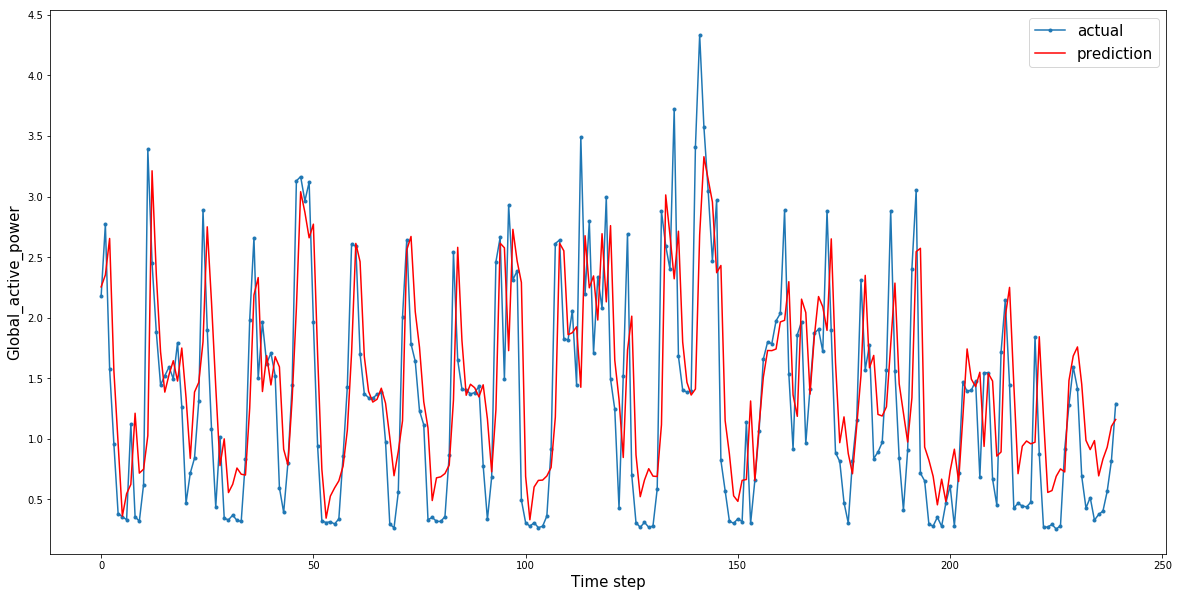

In [35]:
# compare the predictions in 10 days. 

compate_time = 24*10
aa=[x for x in range(compate_time)]
plt.figure(figsize=[20, 10])
plt.plot(aa, inv_y[:compate_time], marker='.', label="actual")
plt.plot(aa, inv_yhat[:compate_time], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()